# Kaggle Time Series Lessons notes

Using the norwegian tunnel dataset, experimenting with **time dummy** variable along with different types of lag. Previously used one type of lag - just next day. Training a Linear Regression model with just nextDay lag produced somewhat poor results. Generally `RMSE = ~10000` and `MAE = ~6000`, `r2 = ~.19`. 

*Update Feb 23*

Significantly improved the above results using a nextWeek lag variable since I noticed that the plot of the actual timeseries repeated every 7 days (it varied by day of the week - no surprise that). `RMSE = ~7000`, `MA = ~4500`, `r2 = ~.7' This is all still pretty dumb but its impressive, at least for this dataset, how well these lag features improve our prediction. 

I haven't tried training with just a nextWeek lag variable, but based on the graphs of lag vs target, it would seem that it should have a much bigger impact on model accuracy than just nextDay lag.

*Update Feb 24*

Going to try to predict with the model.

Already predicting by splitting up the training and validation sets

In [1]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from urllib.parse import urlparse

from statsmodels.tsa.deterministic import DeterministicProcess

import mlflow
import mlflow.sklearn

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

#storing lag variables and the number of days to shift in order to help generalize the code
lag_variables = {'lag_nextDay': 1, 'lag_nextWeek': 7}

tunnel = pd.read_csv('./tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day')
tunn = tunnel.to_period()
print(tunnel.head())
len(tunnel)

            NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569


747

In [2]:
tunnel['time'] = DeterministicProcess(index = tunnel.index, order = 1).in_sample()

#adds in all the lag variables, this models sequential dependence between number of vehicles on current day and previous days (ie, day before and week before)
for lag in lag_variables:
    tunnel[lag] = tunnel['NumVehicles'].shift(lag_variables[lag])

#drops rows with null values since we can't use empty values when training
tunnel.dropna(inplace = True)


print(tunnel.head())

            NumVehicles  time  lag_nextDay  lag_nextWeek
Day                                                     
2003-11-08        96806   8.0     113111.0      103536.0
2003-11-09        86811   9.0      96806.0       92051.0
2003-11-10        99194  10.0      86811.0      100795.0
2003-11-11       102253  11.0      99194.0      102352.0
2003-11-12       105707  12.0     102253.0      106569.0


Below is the lag plot of next day lag

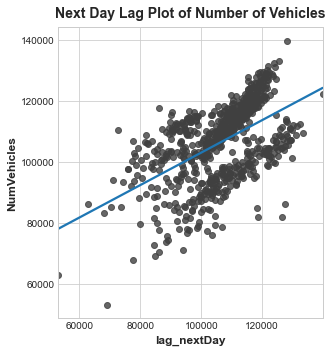

In [3]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_nextDay', y='NumVehicles', data=tunnel, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Next Day Lag Plot of Number of Vehicles');

Next week lag chart

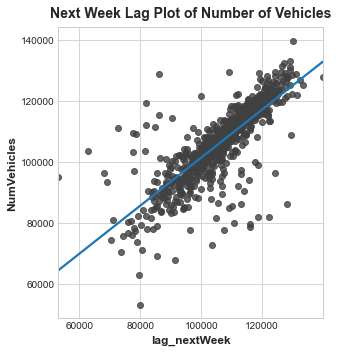

In [4]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_nextWeek', y='NumVehicles', data=tunnel, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Next Week Lag Plot of Number of Vehicles');

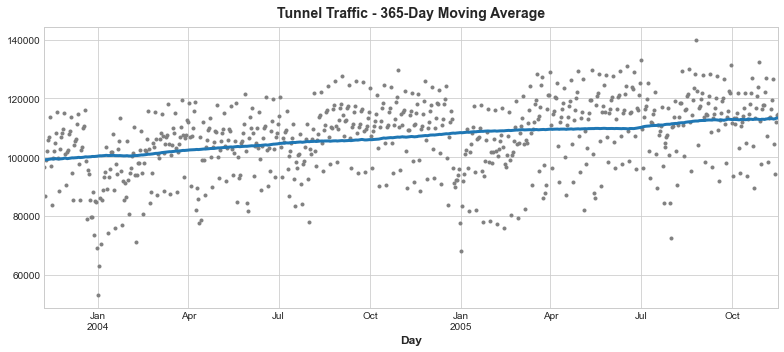

In [6]:
moving_average = tunnel['NumVehicles'].rolling(window = 365, center = True, min_periods = 183).mean()

ax = tunnel['NumVehicles'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In [6]:

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

Linear Regression model:
  RMSE: 6104.761634914469
  MAE: 4402.456329851144
  R2: 0.6908996404799885
test_perc: 0.25


<ipython-input-7-501179e0c851>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ax" which is no longer supported as of 3.3 and will become an error two minor releases later
  regress_pic = plt.savefig('ts-regress', ax = ax)


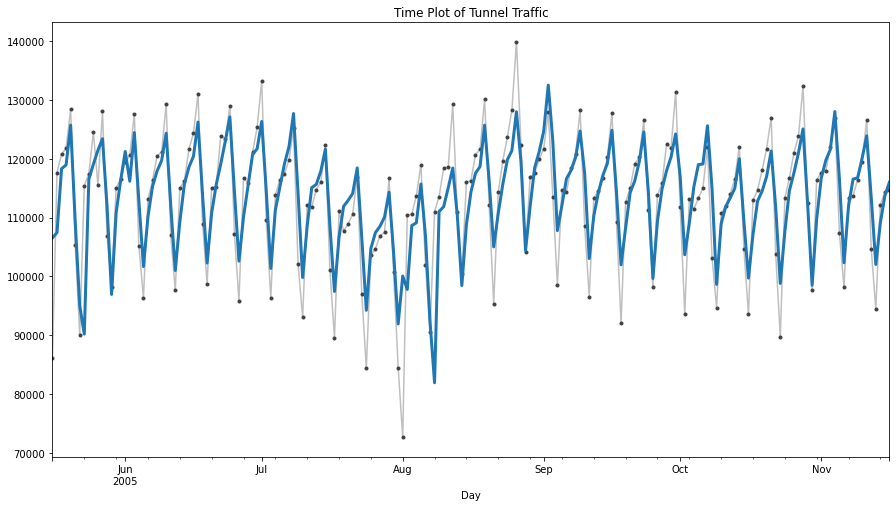

In [7]:
mlflow.set_experiment('cars-through-tunnel')

#determine where to truncate the training set, its timeseries so need to split temporally
test_perc = .25
test_size= round(test_perc * len(tunnel))

# Split the data into training and test sets. (1 - test_perc, test_perc) split.
test = tunnel.iloc[-test_size:, :]
train = tunnel.iloc[:-test_size:, :]

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["NumVehicles"], axis=1)
test_x = test.drop(["NumVehicles"], axis=1)
train_y = train[["NumVehicles"]]
test_y = test[["NumVehicles"]]

with mlflow.start_run():
    model = LinearRegression()
    model.fit(train_x, train_y)
 
    predicted_qualities = model.predict(test_x)
    
    y_pred = pd.Series(predicted_qualities.flatten(), index = test_x.index)
    
    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Linear Regression model:")
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)
    print("test_perc: %s" % test_perc)
    
    ax = test_y.plot(**plot_params)
    ax=y_pred.plot(ax=ax, linewidth = 3, figsize = (15, 8))
    ax.set_title('Time Plot of Tunnel Traffic')

    regress_pic = plt.savefig('ts-regress', ax = ax)

    tags = {'purpose' : 'education',
            'problem' : 'time-series'}

    mlflow.log_param('test_perc', test_perc)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_artifact("ts-regress.png")
    mlflow.set_tags(tags)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme


    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(model, "model", registered_model_name="LinRegTunnelModel")
    else:
        mlflow.sklearn.log_model(model, "model")


    
    #ends the run
    mlflow.end_run()